# Introduction

In this notebook, I examine the neural network approaches. Using the Natural Language Processing in Action book, from Manning Publishing.



In [1]:
import pandas as pd
from nltk import tokenize

In [2]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [3]:
from gensim.models.word2vec import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

In [4]:
%config Completer.use_jedi = False
# this might make autocomplete faster

In [5]:
from sklearn.decomposition import PCA

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
import adjustText

# Word Vectors

Notes from book

LSA: did not capture implied hidden meanings of words

with word vectors: ble to decide things like is this an animal, place, etc, synonyms, 
word vectors are multidimensional vectors that capture the meaning of a word in different dimensions (e.g. animalness, placeness, etc), and then you can do math on it, e.g. vw(marie curie) - vw(science) + vw(music) (who is in music what marie curie is in physics

example: searching for Marie Curie, combine meaning of woman, europe, physics, scientist, famous

pg. 182, abstract example

examples like this lead even beyond google, etc: who is to nuclear physics what louis pasteur is to germs

can answer vgue questions and analogies

word2vec: the google trained neural network released in 2013

not needed to label anything, proximity of words is what matters, so it is unsupervised

(in a way, labels are the words near other words in the dataset)

in lsa, every word that occurs in same document will have impact on score, now, only close words will

pg 187: very short example on how to use

lsa is great for document classification, semantic search, and clustering, but not for semantic reasoning or working with short phrases

word2vec: at time of publication, 40% accurate, went up after being trained on google news corpus

two approaches on how to create word vectors: skip-gram approach and continuous bag-of-words (pg 191 for details)

there are pre-trained ord-vector representations for corpora like wikipedia

fastText: published by facebook

skip-gram: divide text into n-grams, and ... pg 194, not entirely clear

with softmax activation, calculate the probability of an output word being found as a surrounding word of an input word

once training is done, weight matrix will be the embedding


continuous b-o-w approach: instad of creating input - output tokens, multi-hot vector for all surrounding tokens to the center target token

skip-gram approach works well with small corpora and rare terms, cobw is more accurate for frequent words, and faster to train

!stop words should not be ignored, they might carry meaning, plus word vectors are often used in generative models

so they remain in, and to reduce emphasis, they are sampled in inverse proportion of their frequency

small corpus: negative sampling rate of 5-20, large: can reduce to 2 to 5

trying base example on pg 200, using the original pretrained thing

new versions like GloVe, can be trained on smaller corpus and still converge

fasttext uses n-character grams, can also be loaded in gensim, just like word2vec (pg 206)




plots labels: needs adjustText, pip install, github: 
https://github.com/Phlya/adjustText

## Pretrained Examples

In [7]:
# this step takes a while
word_vectors = KeyedVectors.load_word2vec_format(\
    './word2vec_pretrained/GoogleNews-vectors-negative300.bin.gz', binary = True, limit = 1000000)

In [8]:
# finding synonyms
word_vectors.most_similar(positive=['france', 'germany'], topn = 10)

[('europe', 0.7222039103507996),
 ('spain', 0.701023519039154),
 ('european', 0.6962700486183167),
 ('german', 0.6810604929924011),
 ('italy', 0.6680153608322144),
 ('england', 0.66745924949646),
 ('usa', 0.6651221513748169),
 ('switzerland', 0.6604776978492737),
 ('sweden', 0.6577832698822021),
 ('india', 0.6428229808807373)]

In [9]:
# finding odd one outs
word_vectors.doesnt_match(['Hitler', 'Churchill', 'Stalin', 'Beethoven'])

/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'Beethoven'

In [10]:
# famous math operations
word_vectors.most_similar(positive = ['king', 'woman'], negative = ['man'], topn = 1)

[('queen', 0.7118192911148071)]

In [11]:
word_vectors.most_similar(positive = ['doctor', 'woman'], negative = ['man'], topn = 1)

[('gynecologist', 0.7093892097473145)]

In [12]:
word_vectors.most_similar(positive = ['father', 'woman'], negative = ['man'], topn = 1)

[('mother', 0.8462507128715515)]

In [56]:
word_vectors.most_similar(positive = ['Shakespeare', 'theater'], negative = ['Macbeth'])

[('repertory_theater', 0.5712003707885742),
 ('Theater', 0.5682459473609924),
 ('Theatre', 0.5592392086982727),
 ('performing_arts', 0.5544595718383789),
 ('cinema', 0.5379453897476196),
 ('playhouse', 0.5297478437423706),
 ('musicals', 0.527795672416687),
 ('Playhouse', 0.5240913033485413),
 ('Stagecrafters', 0.5200196504592896),
 ('theatregoing', 0.5177725553512573)]

In [13]:
word_vectors.most_similar(positive = ['music', 'Picasso'], negative = ['Beethoven'], topn = 10)

[('art', 0.5378468036651611),
 ('artists', 0.5258477926254272),
 ('Pablo_Picasso', 0.49319028854370117),
 ('artist', 0.49227362871170044),
 ('artwork', 0.47473448514938354),
 ('painting', 0.46198058128356934),
 ('artist_Robert_Rauschenberg', 0.43100041151046753),
 ('artworks', 0.4306104779243469),
 ('painters', 0.43055960536003113),
 ('photography', 0.42579764127731323)]

In [14]:
word_vectors.most_similar(positive = ['Picasso', 'music'], negative = ['art'], topn = 10)

[('Erroll_Garner', 0.5344928503036499),
 ('songs', 0.5321550965309143),
 ('Beethoven', 0.5134056806564331),
 ('Frampton_Comes_Alive', 0.5108814835548401),
 ("Chico_O'Farrill", 0.5059295892715454),
 ('Jimi_Hendrix', 0.5056772232055664),
 ('Mozart', 0.5042005777359009),
 ('Manu_Dibango', 0.49042925238609314),
 ('Chucho_Valdes', 0.4867725372314453),
 ('Mose_Allison', 0.4866839051246643)]

In [15]:
word_vectors.most_similar(positive = ['China', 'Stalin'], negative = ['Russia'], topn = 10)

[('Mao', 0.7007876634597778),
 ('Chairman_Mao', 0.6467739343643188),
 ('Mao_Zedong', 0.5951652526855469),
 ('Mao_Tse_tung', 0.5835192203521729),
 ('Deng_Xiaoping', 0.5821856260299683),
 ('Chairman_Mao_Zedong', 0.5699514150619507),
 ('Communist', 0.5632455348968506),
 ('Communist_Party_CCP', 0.5581366419792175),
 ('Hu_Yaobang', 0.5552926063537598),
 ('Great_Helmsman', 0.5500338077545166)]

In [16]:
word_vectors.most_similar(positive = ['Germany', 'Stalin'], negative = ['Russia'], topn = 10)

[('Hitler', 0.6709142923355103),
 ('Adolf_Hitler', 0.5992249250411987),
 ('Third_Reich', 0.5972428917884827),
 ('Nazi', 0.5926545858383179),
 ('Nazis', 0.5889713764190674),
 ('Hitler_Third_Reich', 0.5791662931442261),
 ('Hilter', 0.5716949701309204),
 ('Adolph_Hitler', 0.5711631774902344),
 ('Nazi_Germany', 0.5646259784698486),
 ('Fuehrer', 0.5622488856315613)]

In [17]:
word_vectors.most_similar(positive = ['France', 'Stalin'], negative = ['Russia'], topn = 10)

[('Pétain', 0.608258843421936),
 ('Mitterand', 0.5562480688095093),
 ('Maurice_Papon', 0.5539685487747192),
 ('De_Gaulle', 0.5534417033195496),
 ('Petain', 0.5488604307174683),
 ('de_Gaulle', 0.5444628000259399),
 ('François_Mitterrand', 0.5440154075622559),
 ('Vichy', 0.5330964922904968),
 ('Francois_Mitterand', 0.5310631990432739),
 ('Hitler', 0.5308597087860107)]

In [18]:
word_vectors.most_similar(positive = ['Hungary', 'Stalin'], negative = ['Russia'], topn = 10)

[('Ceaucescu', 0.5413000583648682),
 ('Gyula', 0.5344285368919373),
 ('Hitler', 0.5297396183013916),
 ('Imre_Nagy', 0.5281765460968018),
 ('Ferenc', 0.5272859930992126),
 ('Mussolini', 0.5254130959510803),
 ('Miklós', 0.5238747596740723),
 ('László', 0.5185155868530273),
 ('Goebbels', 0.514951229095459),
 ('Sándor', 0.5110854506492615)]

Let's see if we can draw a map of european capitals. 

In [19]:
pca = PCA(n_components = 2)

In [28]:
capitals_1 = ['Amsterdam', 'Athens', 'Belgrade', 'Berlin', 'Bern']
# works quite well with these

capitals_2 = [
    'Amsterdam', 'Athens', 'Belgrade', 'Berlin', 'Bern', 
    'Bratislava', 'Brussels', 'Bucharest', 'Budapest', 'Chisinau', 'Copenhagen',
    'Dublin', 'Helsinki', 'Kiev', 'Lisbon', 'Ljubljana', 'London', 'Luxembourg',
    'Madrid', 'Minsk', 'Monaco', 'Moscow', 'Nicosia', 'Nuuk', 'Oslo', 'Paris',
    'Podgorica', 'Prague', 'Reykjavik', 'Riga', 'Rome', 'San_Marino', 'Sarajevo',
    'Skopje', 'Sofia', 'Stockholm', 'Tallinn', 'Tirana', 'Vaduz', 'Valletta',
    'Vatican', 'Vienna', 'Vilnius', 'Warsaw', 'Zagreb']

nope = ['Andorra_la_Vella']

In [29]:
capital_plus_coordinates = []

for capital in capitals_2: 
    
    current_row = []
    current_row.append(capital)
    current_row.extend(word_vectors[capital])

    capital_plus_coordinates.append(current_row)
    
capital_plus_coordinates = pd.DataFrame(capital_plus_coordinates)

In [30]:
coordinates_2d = pca.fit_transform(capital_plus_coordinates.iloc[:,1:300])

coordinates_2d = pd.DataFrame(coordinates_2d, columns=["x", "y"])

In [31]:
coordinates_2d['city'] = capital_plus_coordinates.iloc[:,0]

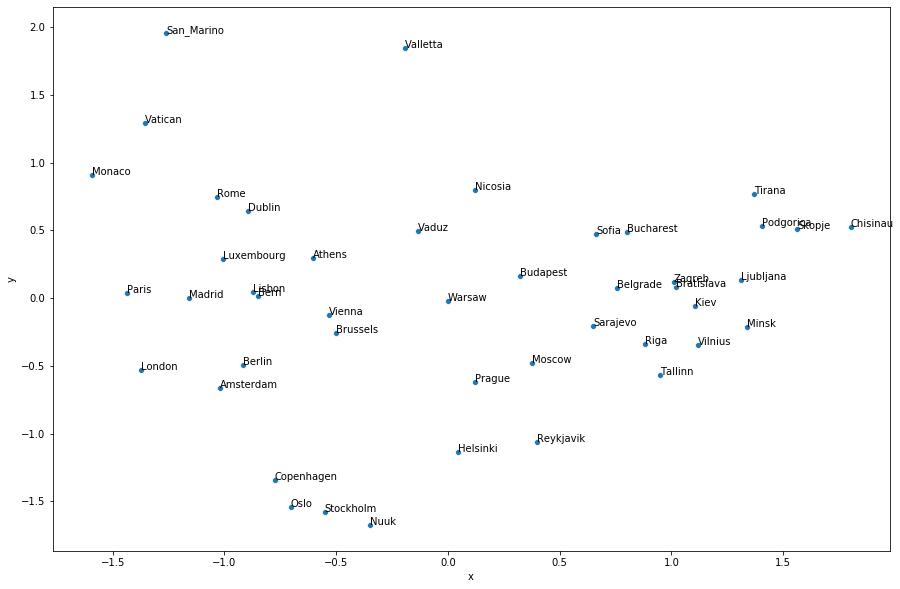

In [32]:
plt.figure(figsize = (15,10))

p1=sns.scatterplot(
    data=coordinates_2d, x="x", y="y")
 
# add annotations one by one with a loop
for line in range(0,coordinates_2d.shape[0]):
     p1.text(coordinates_2d.x[line], coordinates_2d.y[line], coordinates_2d.city[line])

In [33]:
# lets flip its vertical axis

coordinates_2d['y'] = coordinates_2d['y'] * (-1)

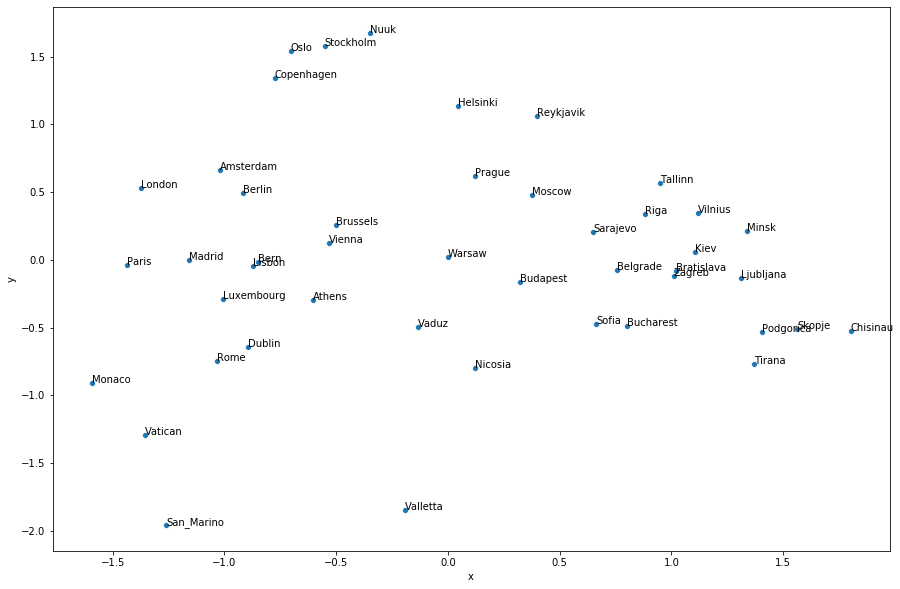

In [35]:
plt.figure(figsize = (15,10))

p1=sns.scatterplot(
    data=coordinates_2d, x="x", y="y")
 
# add annotations one by one with a loop
for city in range(0,coordinates_2d.shape[0]):
     p1.text(coordinates_2d.x[city], coordinates_2d.y[city], coordinates_2d.city[city])

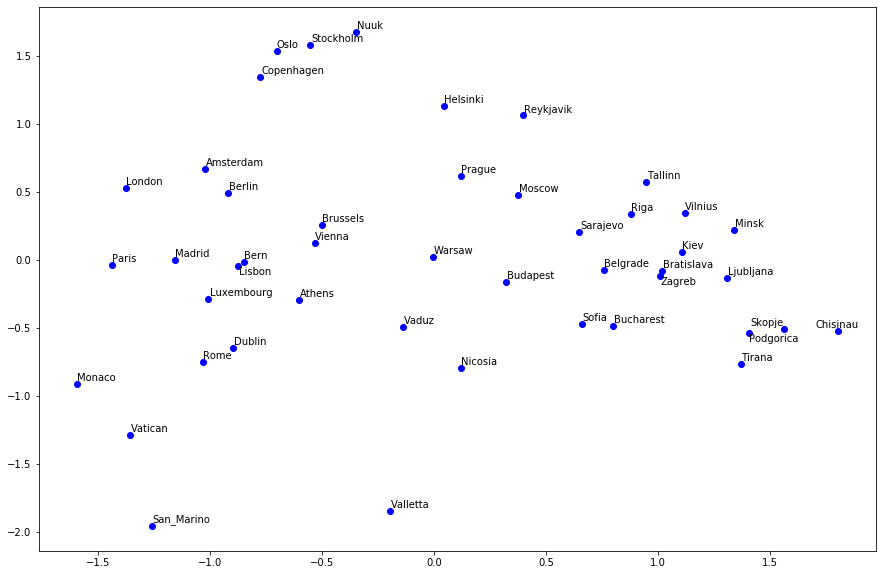

In [49]:
x = coordinates_2d['x']
y = coordinates_2d['y']
label = coordinates_2d['city']

plt.figure(figsize = (15,10))

# p1=sns.scatterplot(
#     data=coordinates_2d, x="x", y="y")


plt.plot(x, y, 'bo')

texts = [plt.text(x[i], y[i], label[i]) for i in range(len(x))]

adjustText.adjust_text(texts)

plt.show()

In [229]:
def plot_2d_representation_of_words(
    word_list, 
    word_vectors, 
    flip_x_axis = False,
    flip_y_axis = False,
    label_x_axis = "x",
    label_y_axis = "y", 
    label_label = "city"):
    """
    does a principal component analysis on word vectors, 
    plots them on a 2d plot
    """
    
    word_plus_coordinates=[]
    
    for word in word_list: 
    
        current_row = []
        current_row.append(word)
        current_row.extend(word_vectors[word])

        word_plus_coordinates.append(current_row)
    
    word_plus_coordinates = pd.DataFrame(word_plus_coordinates)
        
    coordinates_2d = pca.fit_transform(
        word_plus_coordinates.iloc[:,1:300])
    coordinates_2d = pd.DataFrame(
        coordinates_2d, columns=[label_x_axis, label_y_axis])
    coordinates_2d[label_label] = word_plus_coordinates.iloc[:,0]

    if flip_x_axis:
        coordinates_2d[label_x_axis] = coordinates_2d[label_x_axis] * (-1)

    if flip_y_axis:
        coordinates_2d[label_y_axis] = coordinates_2d[label_y_axis] * (-1)
            
    plt.figure(figsize = (15,10))

    p1=sns.scatterplot(
        data=coordinates_2d, x=label_x_axis, y=label_y_axis)

    # add annotations one by one with a loop
    for line in range(0,coordinates_2d.shape[0]):
         p1.text(
             coordinates_2d[label_x_axis][line], 
             coordinates_2d[label_y_axis][line], 
             coordinates_2d[label_label][line])

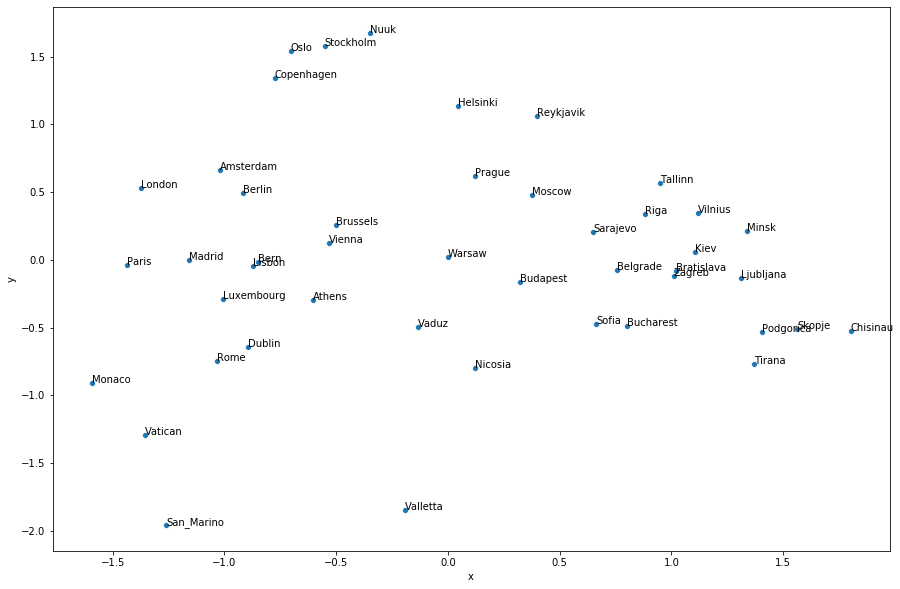

In [218]:
plot_2d_representation_of_words(
    word_list = capitals_2, 
    word_vectors = word_vectors, 
    flip_y_axis = True)

In [257]:
presidents = [
    'Donald_Trump', 'Barack_Obama', 'George_W._Bush', 'Bill_Clinton', 
    'Ronald_Reagan', 'Jimmy_Carter', 'Gerald_Ford', 'Richard_Nixon', 
    'Lyndon_B._Johnson', 'John_F._Kennedy', 'Dwight_D._Eisenhower', 
    'Harry_Truman', 'Franklin_D._Roosevelt', 'Herbert_Hoover', 'Calvin_Coolidge',
    'Woodrow_Wilson', 'Theodore_Roosevelt']


# missing: George Bush, Warren G Harding, William Howard Taft

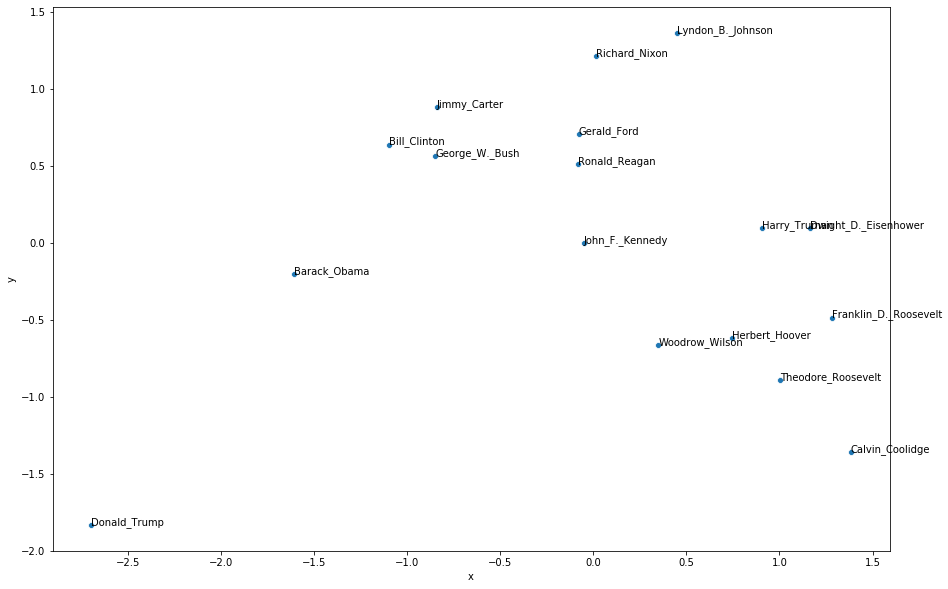

In [260]:
plot_2d_representation_of_words(
    word_list = presidents, 
    word_vectors = word_vectors, 
    flip_x_axis = True, flip_y_axis = True)

## Training Own

As a first step, we need text split into sentences. 

In [1]:
# this is the folder that should be used: 
txt_folder = './data/original/txts_adjusted/'

In [4]:
df = pd.read_csv('./data/original/table_of_contents.csv', header = None, \
                 names = ['original_title', 'page_num','filename','year'])

# skipping first one
filenames =  df['filename'][1:]

In [63]:
# trying with one story

my_file = open(txt_folder + 'the_dunwich_horror.txt')
raw_text = my_file.read()
my_file.close()

# create tokenized in the required format, 
# list of sentences, each sentence is a list of tokens

sentences = tokenize.sent_tokenize(raw_text)
sentences_tokenized = []

for sentence in sentences:
    sentence_tokenized = nlp(sentence)
    sentences_tokenized_list = []
    for token in sentence_tokenized:
        sentences_tokenized_list.append(token.lemma_)
    sentences_tokenized.append(sentences_tokenized_list)

In [103]:
model = Word2Vec(
    sentences_tokenized, 
    workers = -1, 
    size = 100, 
    min_count = 3, 
    window = 10, 
    sample = 5)

# increasing sample means that we won't get boring stopwords in the results
# min count = 3, otherwise for example daughter are excluded

model.init_sims(replace = True) 
# to get rid of unnecessary stuff in memory

In [104]:
model.wv.most_similar(positive = ['horror'])

[('watch', 0.2908990979194641),
 ('rite', 0.28141331672668457),
 ('abandon', 0.2760845720767975),
 ('rush', 0.27406400442123413),
 ('complete', 0.26243871450424194),
 ('ready', 0.2602434754371643),
 ('voice', 0.25994643568992615),
 ('none', 0.2586766481399536),
 ('fail', 0.2547798156738281),
 ('cave', 0.24298059940338135)]

In [105]:
model.wv.most_similar(positive = ['Whateley'], negative = ['horror'])

[('unison', 0.3200337588787079),
 ('everybody', 0.30372485518455505),
 ('community', 0.2893528342247009),
 ('white', 0.281683087348938),
 ('unseen', 0.27846288681030273),
 ('vital', 0.2618259787559509),
 ('Sawyer', 0.24717813730239868),
 ('either', 0.2439933717250824),
 ('tarry', 0.24331888556480408),
 ('month', 0.23465459048748016)]

In [106]:
model.wv.most_similar(positive = ['Rice', 'Professor'], negative = ['Morgan'])

[('sphere', 0.35368138551712036),
 ('quite', 0.29772794246673584),
 ('power', 0.2661077380180359),
 ('even', 0.24735844135284424),
 (';', 0.24534285068511963),
 ('need', 0.24197405576705933),
 ('raound', 0.24109742045402527),
 ('inclined', 0.2403174787759781),
 ('sickly', 0.23939597606658936),
 ('unmistakably', 0.2393909990787506)]

In [111]:
model.wv.doesnt_match(['Armitage', 'Rice', 'Morgan', 'Wilbur', 'Whateley'])

/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'Morgan'

In [122]:
# trying with all the stories

sentences_tokenized = []

for filename in filenames[:3]: 
    
    print(filename)

    my_file = open(txt_folder + filename + '.txt')
    raw_text = my_file.read()
    my_file.close()

    # create tokenized in the required format, 
    # list of sentences, each sentence is a list of tokens

    sentences = tokenize.sent_tokenize(raw_text)

    for sentence in sentences:
        sentence_tokenized = nlp(sentence)
        sentence_tokenized_list = []
        for token in sentence_tokenized:
            
            # TODO probably exclude punctuations, do lowercase
            # maybe keep original
            
            sentence_tokenized_list.append(token.lemma_)
        sentences_tokenized.append(sentence_tokenized_list)

the_tomb
dagon
polaris


In [123]:
len(sentences_tokenized)

287

In [126]:
sentences_tokenized[100]

['-PRON-',
 'have',
 'tell',
 'no',
 'one',
 'of',
 '-PRON-',
 'visit',
 'to',
 'the',
 'tomb',
 ',',
 'have',
 '\n',
 'guard',
 '-PRON-',
 'secret',
 'purpose',
 'with',
 'religious',
 'zeal',
 'since',
 'childhood',
 ';',
 'but',
 'now',
 '-PRON-',
 'be',
 'force',
 'to',
 '\n',
 'exercise',
 'care',
 'in',
 'thread',
 'the',
 'maze',
 'of',
 'the',
 'wooded',
 'hollow',
 ',',
 'that',
 '-PRON-',
 'may',
 'throw',
 'off',
 'a',
 'possible',
 '\n',
 'pursuer',
 '.']